<a href="https://colab.research.google.com/github/Suman-Adhikary/MOVIESVERSE/blob/main/CONTENT_BASED_MOVIE_RECOMMENDED_SYSTEM_USING_TENSORFLOW_AND_COSINE_SIMILARITY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Enable GPU.

---



---



In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16390485008630860177
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14337966080
locality {
  bus_id: 1
  links {
    link {
      device_id: 1
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 12419648760660414659
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 14337966080
locality {
  bus_id: 1
  links {
    link {
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 10334044682244146005
physical_device_desc: "device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5"
xla_global_id: 2144165316
]


In [ ]:
import tensorflow as tf

print("GPU Available:", tf.config.list_physical_devices('GPU'))

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


# Import Required Packages.

---



---



In [ ]:
!pip install pyspark
from pandas import DataFrame
import gc
import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
import pyspark
from pyspark.sql import SparkSession
import pickle
from sklearn.preprocessing import MinMaxScaler
from pyspark.sql import Row
from sklearn.model_selection import train_test_split
from pyspark.sql.functions import split, explode
import pyspark.sql.functions as f
from pyspark.sql.functions import explode
from pyspark.sql.window import Window
from pyspark.sql.functions import monotonically_increasing_id, collect_list
from pyspark.sql.types import MapType, IntegerType, ArrayType
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.metrics import r2_score,mean_absolute_percentage_error, mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=63c77a1204777068e2fa26bbc79985205ea9b95ac5812aac8e708549e7a676a4
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


# Setup SparkSesion.

---



---



In [ ]:
spark = SparkSession.builder.appName('Recommended System').getOrCreate()

# Import and Read Dataset.

---



---



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Genome Scores Dataset.

---



In [ ]:
%%time
df_genome_scores = spark.read.option('header', 'true').csv('/content/drive/MyDrive/MovieLens Dataset/genome-scores.csv')
df_genome_scores.show()

+-------+-----+--------------------+
|movieId|tagId|           relevance|
+-------+-----+--------------------+
|      1|    1|0.028749999999999998|
|      1|    2|0.023749999999999993|
|      1|    3|              0.0625|
|      1|    4| 0.07574999999999998|
|      1|    5|             0.14075|
|      1|    6|             0.14675|
|      1|    7|              0.0635|
|      1|    8|             0.20375|
|      1|    9|               0.202|
|      1|   10|             0.03075|
|      1|   11|             0.58025|
|      1|   12| 0.10249999999999998|
|      1|   13| 0.20174999999999998|
|      1|   14|0.007000000000000006|
|      1|   15|0.024500000000000022|
|      1|   16| 0.17275000000000001|
|      1|   17|0.016500000000000015|
|      1|   18| 0.10399999999999998|
|      1|   19|              0.6625|
|      1|   20| 0.30074999999999996|
+-------+-----+--------------------+
only showing top 20 rows

CPU times: user 76.9 ms, sys: 17.8 ms, total: 94.7 ms
Wall time: 15.4 s


In [ ]:
print(f"Genome Scores Data Shape : {(df_genome_scores.count(), len(df_genome_scores.columns))}")

Genome Scores Data Shape : (15584448, 3)


## Genome Tags Dataset.

---



In [ ]:
%%time
df_genome_tags = spark.read.option('header', 'true').csv('/content/drive/MyDrive/MovieLens Dataset/genome-tags.csv')
df_genome_tags.show()

+-----+---------------+
|tagId|            tag|
+-----+---------------+
|    1|            007|
|    2|   007 (series)|
|    3|   18th century|
|    4|          1920s|
|    5|          1930s|
|    6|          1950s|
|    7|          1960s|
|    8|          1970s|
|    9|          1980s|
|   10|   19th century|
|   11|             3d|
|   12|           70mm|
|   13|            80s|
|   14|           9/11|
|   15|        aardman|
|   16|aardman studios|
|   17|       abortion|
|   18|         absurd|
|   19|         action|
|   20|  action packed|
+-----+---------------+
only showing top 20 rows

CPU times: user 12.7 ms, sys: 149 µs, total: 12.8 ms
Wall time: 1.39 s


In [ ]:
print(f"Genome Tags Data Shape : {(df_genome_tags.count(), len(df_genome_tags.columns))}")

Genome Tags Data Shape : (1128, 2)


## Links Dataset.

---



In [ ]:
%%time
df_links = spark.read.option('header', 'true').csv('/content/drive/MyDrive/MovieLens Dataset/links.csv')
df_links.show()

+-------+-------+------+
|movieId| imdbId|tmdbId|
+-------+-------+------+
|      1|0114709|   862|
|      2|0113497|  8844|
|      3|0113228| 15602|
|      4|0114885| 31357|
|      5|0113041| 11862|
|      6|0113277|   949|
|      7|0114319| 11860|
|      8|0112302| 45325|
|      9|0114576|  9091|
|     10|0113189|   710|
|     11|0112346|  9087|
|     12|0112896| 12110|
|     13|0112453| 21032|
|     14|0113987| 10858|
|     15|0112760|  1408|
|     16|0112641|   524|
|     17|0114388|  4584|
|     18|0113101|     5|
|     19|0112281|  9273|
|     20|0113845| 11517|
+-------+-------+------+
only showing top 20 rows

CPU times: user 11.9 ms, sys: 342 µs, total: 12.2 ms
Wall time: 1.57 s


In [ ]:
print(f"Links Data Shape : {(df_links.count(), len(df_links.columns))}")

Links Data Shape : (62423, 3)


## Movies Dataset.

---



In [ ]:
%%time
df_movies = spark.read.option('header', 'true').csv('/content/drive/MyDrive/MovieLens Dataset/movies.csv')
df_movies.show()

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
|      6|         Heat (1995)|Action|Crime|Thri...|
|      7|      Sabrina (1995)|      Comedy|Romance|
|      8| Tom and Huck (1995)|  Adventure|Children|
|      9| Sudden Death (1995)|              Action|
|     10|    GoldenEye (1995)|Action|Adventure|...|
|     11|American Presiden...|Comedy|Drama|Romance|
|     12|Dracula: Dead and...|       Comedy|Horror|
|     13|        Balto (1995)|Adventure|Animati...|
|     14|        Nixon (1995)|               Drama|
|     15|Cutthroat Island ...|Action|Adventure|...|
|     16|       Casino (1995)|         Crime|Drama|
|     17|Sen

In [ ]:
print(f"Movies Data Shape : {(df_movies.count(), len(df_movies.columns))}")

Movies Data Shape : (62423, 3)


## Ratings Dataset.

---



In [ ]:
%%time
df_ratings = spark.read.option('header', 'true').csv('/content/drive/MyDrive/MovieLens Dataset/ratings.csv')
df_ratings.show()

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|    296|   5.0|1147880044|
|     1|    306|   3.5|1147868817|
|     1|    307|   5.0|1147868828|
|     1|    665|   5.0|1147878820|
|     1|    899|   3.5|1147868510|
|     1|   1088|   4.0|1147868495|
|     1|   1175|   3.5|1147868826|
|     1|   1217|   3.5|1147878326|
|     1|   1237|   5.0|1147868839|
|     1|   1250|   4.0|1147868414|
|     1|   1260|   3.5|1147877857|
|     1|   1653|   4.0|1147868097|
|     1|   2011|   2.5|1147868079|
|     1|   2012|   2.5|1147868068|
|     1|   2068|   2.5|1147869044|
|     1|   2161|   3.5|1147868609|
|     1|   2351|   4.5|1147877957|
|     1|   2573|   4.0|1147878923|
|     1|   2632|   5.0|1147878248|
|     1|   2692|   5.0|1147869100|
+------+-------+------+----------+
only showing top 20 rows

CPU times: user 15.4 ms, sys: 0 ns, total: 15.4 ms
Wall time: 1.53 s


In [ ]:
print(f"Ratings Data Shape : {(df_ratings.count(), len(df_ratings.columns))}")

Ratings Data Shape : (25000095, 4)


## Tags Dataset.

---



In [ ]:
%%time
df_tags = spark.read.option('header', 'true').csv('/content/drive/MyDrive/MovieLens Dataset/tags.csv')
df_tags.show()

+------+-------+--------------------+----------+
|userId|movieId|                 tag| timestamp|
+------+-------+--------------------+----------+
|     3|    260|             classic|1439472355|
|     3|    260|              sci-fi|1439472256|
|     4|   1732|         dark comedy|1573943598|
|     4|   1732|      great dialogue|1573943604|
|     4|   7569|    so bad it's good|1573943455|
|     4|  44665|unreliable narrators|1573943619|
|     4| 115569|               tense|1573943077|
|     4| 115713|artificial intell...|1573942979|
|     4| 115713|       philosophical|1573943033|
|     4| 115713|               tense|1573943042|
|     4| 148426|    so bad it's good|1573942965|
|     4| 164909|              cliche|1573943721|
|     4| 164909|             musical|1573943714|
|     4| 168250|              horror|1573945163|
|     4| 168250|       unpredictable|1573945171|
|    19|   2160|Oscar (Best Suppo...|1446909853|
|    19|   7099|           adventure|1445286141|
|    19|   7099|    

In [ ]:
print(f"Tags Data Shape : {(df_tags.count(), len(df_tags.columns))}")

Tags Data Shape : (1093360, 4)


# Exploratory Data Analysis(EDA).

---



---



## Genome Scores Dataset.

---



### Data Types and Columns.

In [ ]:
df_genome_scores.printSchema()

root
 |-- movieId: string (nullable = true)
 |-- tagId: string (nullable = true)
 |-- relevance: string (nullable = true)



### Change Datatype Of Relevance Feature To Interger.

In [ ]:
df_genome_scores = df_genome_scores.withColumn("relevance", df_genome_scores["relevance"].cast('float'))
df_genome_scores.printSchema()

root
 |-- movieId: string (nullable = true)
 |-- tagId: string (nullable = true)
 |-- relevance: float (nullable = true)



### Histogram Of Avarage Relevance Respect To Movie Id.

In [ ]:
# Group by on movieId respect to relevance.
relevance_rating = df_genome_scores.groupBy('movieId').mean('relevance')
relevance_rating.show()

+-------+-------------------+
|movieId|     avg(relevance)|
+-------+-------------------+
|    296|0.20342331544676934|
|    467|0.08196032801556322|
|    691|0.08993971624666766|
|    829|0.08501817372706817|
|   1090|0.19710239373805524|
|   1436|0.09218860813819041|
|   1572|0.10893262399132247|
|   2069| 0.1157535461629229|
|   2088|0.09713408693461514|
|   2136|0.11364162240403619|
|   2162|0.08546343092795904|
|   2294|0.11833333351330647|
|   2904|0.09500709212660056|
|   3210|0.15985505313757833|
|   3414|0.09584264191679148|
|   3606|0.12563430862224673|
|   3959|0.15059286358841392|
|   4032|0.09761391837684048|
|   4821|0.10422340435605885|
|    125|0.12320057627272707|
+-------+-------------------+
only showing top 20 rows



CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 8.34 µs


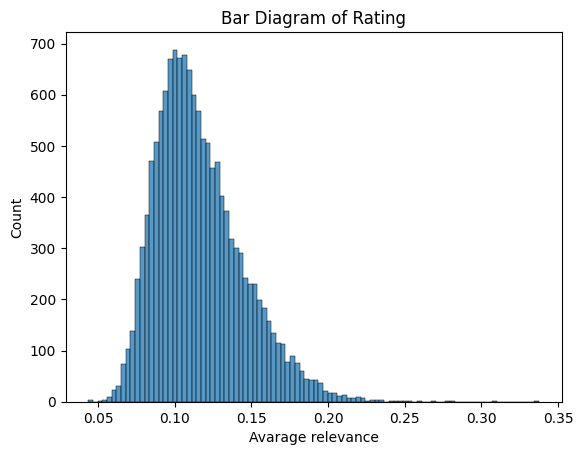

In [ ]:
# Converting spark dataframe to pandas dataframe.
%time
relevance_rating = relevance_rating.toPandas()
sns.histplot(data = relevance_rating, x = 'avg(relevance)')
plt.title('Bar Diagram of Rating')
plt.xlabel('Avarage relevance')
plt.show()

## Rating Dataset.

---



### Find Max and Min Value.

In [ ]:
%%time
max_rating = df_ratings.agg({'rating' : 'max'}).collect()[0][0]
min_rating = df_ratings.agg({'rating' : 'min'}).collect()[0][0]

CPU times: user 544 ms, sys: 59 ms, total: 603 ms
Wall time: 1min 46s


In [ ]:
print(f"The Max Rating : {max_rating}")
print(f"The Min Rating : {min_rating}")

The Max Rating : 5.0
The Min Rating : 0.5


### Groupby Upon Rating Column.

In [ ]:
Rating_Count  = df_ratings.groupBy(df_ratings.rating).count()
Rating_Count.show()

+------+-------+
|rating|  count|
+------+-------+
|   1.0| 776815|
|   4.5|2200539|
|   2.5|1262797|
|   3.5|3177318|
|   5.0|3612474|
|   0.5| 393068|
|   4.0|6639798|
|   1.5| 399490|
|   2.0|1640868|
|   3.0|4896928|
+------+-------+



In [ ]:
Rating_As_Pandas = Rating_Count.toPandas()

### Bar plot of Rating Dataset.



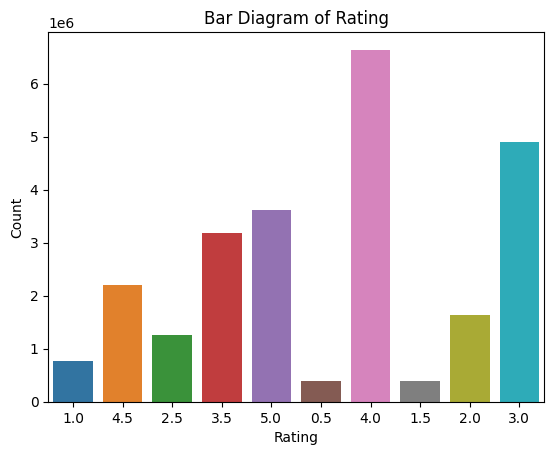

In [ ]:
sns.barplot(data = Rating_As_Pandas, x = 'rating', y = 'count')
plt.title('Bar Diagram of Rating')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

### Histogram of Avarage Rating Respect To MovieId Dataset.

In [ ]:
df_ratings = df_ratings.withColumn("rating", df_ratings["rating"].cast('float'))

In [ ]:
Groupby_respect_to_rating = df_ratings.groupBy('movieId').mean('rating')
Groupby_respect_to_rating.show()

+-------+------------------+
|movieId|       avg(rating)|
+-------+------------------+
|    296| 4.188912039361382|
|   2294|  3.23630794550608|
|  48738|3.8409684723915696|
|  88140| 3.515557328470481|
| 115713|  3.96935522435642|
|   1090|3.9036080019052157|
|   3210|3.6631319358816277|
|   3959|3.6956912028725313|
|  27317|             3.605|
|  50802|2.9479166666666665|
|   2069|3.7973760932944605|
|   2136| 2.855124340617935|
|  89864|3.7292743436014058|
|    675|2.1538461538461537|
|  62912|2.5106382978723403|
| 119655| 2.797169811320755|
|   2088|2.5539083557951483|
|    691|3.0554054054054056|
|   5325|  3.71356783919598|
|   4821|3.1892829606784887|
+-------+------------------+
only showing top 20 rows



In [ ]:
Groupby_respect_to_rating = Groupby_respect_to_rating.toPandas()

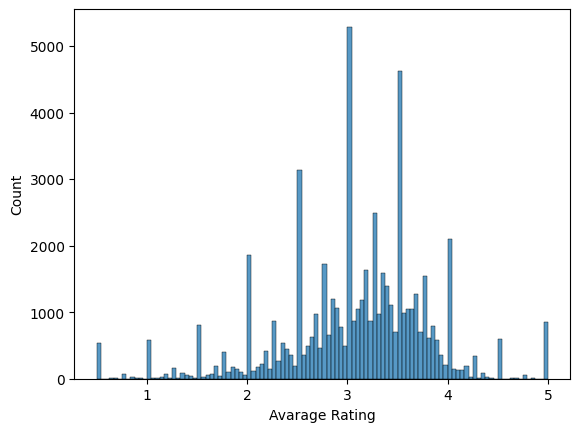

In [ ]:
sns.histplot(data = Groupby_respect_to_rating, x = "avg(rating)")
plt.xlabel('Avarage Rating')
plt.ylabel('Count')
plt.show()

### Histogram of Avarage Rating Respect To UserId.

In [ ]:
Groupby_respect_to_userid = df_ratings.groupBy('userId').mean('rating')
Groupby_respect_to_userid.show()

+------+------------------+
|userId|       avg(rating)|
+------+------------------+
|   296|2.8762886597938144|
|   467|             3.425|
|   675|3.8255813953488373|
|   691| 4.333333333333333|
|   829| 2.942857142857143|
|  1090| 4.148148148148148|
|  1159|3.7471264367816093|
|  1436| 3.485148514851485|
|  1512| 4.390243902439025|
|  1572|3.8369565217391304|
|  2069|3.1373390557939915|
|  2088|               3.8|
|  2136|              4.65|
|  2162| 4.517241379310345|
|  2294|             3.388|
|  2904|              3.75|
|  3210|3.3333333333333335|
|  3414|3.6809210526315788|
|  3606|3.1702127659574466|
|  3959| 2.734982332155477|
+------+------------------+
only showing top 20 rows



In [ ]:
Groupby_respect_to_userid = Groupby_respect_to_userid.toPandas()

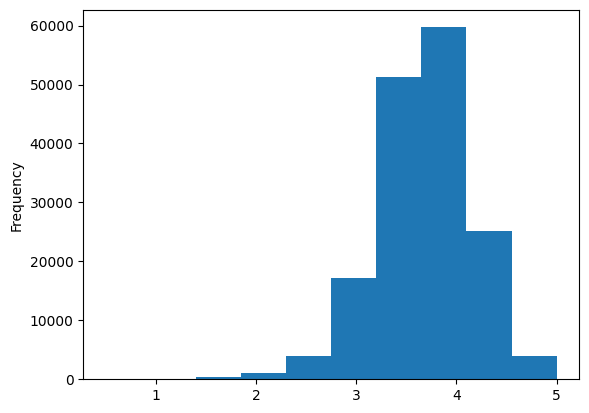

In [ ]:
Groupby_respect_to_userid['avg(rating)'].plot(kind = 'hist')
plt.show()

## Movie Dataset

---



### Common genre movies.

In [ ]:
df_movies.printSchema()

root
 |-- movieId: string (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)



In [ ]:
movies_df = df_movies.toPandas()

In [ ]:
Genres_df = df_movies.withColumn("genre", split(df_movies["genres"], "\|"))
genres = Genres_df.select(f.split(Genres_df['genres'], '\|')).collect()
hashset = set()
for row in genres:
  for ele in row[0]:
    hashset.add(ele)
# hashset.remove(' We\'re Comin\' To Get Ya!"" (2014)"')
print(hashset)
print(len(hashset))

{'Children', 'Crime', 'Action', 'Documentary', 'Western', 'Horror', 'Adventure', 'Fantasy', 'Thriller', 'Mystery', '(no genres listed)', 'Musical', 'Comedy', 'Sci-Fi', 'Drama', 'Romance', 'IMAX', 'Animation', 'Film-Noir', 'War'}
20


In [ ]:
Genres_df.show()

+-------+--------------------+--------------------+--------------------+
|movieId|               title|              genres|               genre|
+-------+--------------------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|[Adventure, Anima...|
|      2|      Jumanji (1995)|Adventure|Childre...|[Adventure, Child...|
|      3|Grumpier Old Men ...|      Comedy|Romance|   [Comedy, Romance]|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|[Comedy, Drama, R...|
|      5|Father of the Bri...|              Comedy|            [Comedy]|
|      6|         Heat (1995)|Action|Crime|Thri...|[Action, Crime, T...|
|      7|      Sabrina (1995)|      Comedy|Romance|   [Comedy, Romance]|
|      8| Tom and Huck (1995)|  Adventure|Children|[Adventure, Child...|
|      9| Sudden Death (1995)|              Action|            [Action]|
|     10|    GoldenEye (1995)|Action|Adventure|...|[Action, Adventur...|
|     11|American Presiden...|Comedy|Drama|Romance|

In [ ]:
df, row_i, col_i = [[0 for i in range(len(hashset))] for j in range(len(genres))], 0, 0
for genre in hashset:
  row_i = 0
  for row in genres:
      if genre in row[0]:
        df[row_i][col_i] = 1
      else:
        df[row_i][col_i] = 0
      row_i += 1
  col_i += 1
movieid_title = Genres_df.select("movieid","title", "genre")
movieid_title.show()

+-------+--------------------+--------------------+
|movieid|               title|               genre|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|[Adventure, Anima...|
|      2|      Jumanji (1995)|[Adventure, Child...|
|      3|Grumpier Old Men ...|   [Comedy, Romance]|
|      4|Waiting to Exhale...|[Comedy, Drama, R...|
|      5|Father of the Bri...|            [Comedy]|
|      6|         Heat (1995)|[Action, Crime, T...|
|      7|      Sabrina (1995)|   [Comedy, Romance]|
|      8| Tom and Huck (1995)|[Adventure, Child...|
|      9| Sudden Death (1995)|            [Action]|
|     10|    GoldenEye (1995)|[Action, Adventur...|
|     11|American Presiden...|[Comedy, Drama, R...|
|     12|Dracula: Dead and...|    [Comedy, Horror]|
|     13|        Balto (1995)|[Adventure, Anima...|
|     14|        Nixon (1995)|             [Drama]|
|     15|Cutthroat Island ...|[Action, Adventur...|
|     16|       Casino (1995)|      [Crime, Drama]|
|     17|Sen

In [ ]:
movieid_title.count()

62423

In [ ]:
genre_df = DataFrame.from_records(df)
genre_df = spark.createDataFrame(genre_df,schema=list(hashset))
window_spec = Window.orderBy("Sci-Fi")
genre_df = genre_df.withColumn("index", f.row_number().over(window_spec)-1)
movieid_title = movieid_title.withColumn("index", monotonically_increasing_id())
Genre_split = movieid_title.join(genre_df, 'index')

In [ ]:
genre_df.count()

62423

In [ ]:
movieid_title.show()

+-------+--------------------+--------------------+-----+
|movieid|               title|               genre|index|
+-------+--------------------+--------------------+-----+
|      1|    Toy Story (1995)|[Adventure, Anima...|    0|
|      2|      Jumanji (1995)|[Adventure, Child...|    1|
|      3|Grumpier Old Men ...|   [Comedy, Romance]|    2|
|      4|Waiting to Exhale...|[Comedy, Drama, R...|    3|
|      5|Father of the Bri...|            [Comedy]|    4|
|      6|         Heat (1995)|[Action, Crime, T...|    5|
|      7|      Sabrina (1995)|   [Comedy, Romance]|    6|
|      8| Tom and Huck (1995)|[Adventure, Child...|    7|
|      9| Sudden Death (1995)|            [Action]|    8|
|     10|    GoldenEye (1995)|[Action, Adventur...|    9|
|     11|American Presiden...|[Comedy, Drama, R...|   10|
|     12|Dracula: Dead and...|    [Comedy, Horror]|   11|
|     13|        Balto (1995)|[Adventure, Anima...|   12|
|     14|        Nixon (1995)|             [Drama]|   13|
|     15|Cutth

In [ ]:
movieid_title.agg({'index' : 'max'}).collect()[0][0], movieid_title.agg({'index' : 'min'}).collect()[0][0]

(62422, 0)

In [ ]:
movieid_title.count()

62423

In [ ]:
genre_df.show()

+--------+-----+------+-----------+-------+------+---------+-------+--------+-------+------------------+-------+------+------+-----+-------+----+---------+---------+---+-----+
|Children|Crime|Action|Documentary|Western|Horror|Adventure|Fantasy|Thriller|Mystery|(no genres listed)|Musical|Comedy|Sci-Fi|Drama|Romance|IMAX|Animation|Film-Noir|War|index|
+--------+-----+------+-----------+-------+------+---------+-------+--------+-------+------------------+-------+------+------+-----+-------+----+---------+---------+---+-----+
|       1|    0|     0|          0|      0|     0|        1|      1|       0|      0|                 0|      0|     1|     0|    0|      0|   0|        1|        0|  0|    0|
|       1|    0|     0|          0|      0|     0|        1|      1|       0|      0|                 0|      0|     0|     0|    0|      0|   0|        0|        0|  0|    1|
|       0|    0|     0|          0|      0|     0|        0|      0|       0|      0|                 0|      0|     1| 

In [ ]:
genre_df.count()

62423

In [ ]:
Genre_split.show()

+-----+-------+--------------------+--------------------+--------+-----+------+-----------+-------+------+---------+-------+--------+-------+------------------+-------+------+------+-----+-------+----+---------+---------+---+
|index|movieid|               title|               genre|Children|Crime|Action|Documentary|Western|Horror|Adventure|Fantasy|Thriller|Mystery|(no genres listed)|Musical|Comedy|Sci-Fi|Drama|Romance|IMAX|Animation|Film-Noir|War|
+-----+-------+--------------------+--------------------+--------+-----+------+-----------+-------+------+---------+-------+--------+-------+------------------+-------+------+------+-----+-------+----+---------+---------+---+
|    0|      1|    Toy Story (1995)|[Adventure, Anima...|       1|    0|     0|          0|      0|     0|        1|      1|       0|      0|                 0|      0|     1|     0|    0|      0|   0|        1|        0|  0|
|    1|      2|      Jumanji (1995)|[Adventure, Child...|       1|    0|     0|          0|     

In [ ]:
Genre_split.count()

62423

In [ ]:
movies_exploded = Genre_split.select("*", explode("genre").alias("exploded_genre"))
movies_exploded.show()

+-----+-------+--------------------+--------------------+--------+-----+------+-----------+-------+------+---------+-------+--------+-------+------------------+-------+------+------+-----+-------+----+---------+---------+---+--------------+
|index|movieid|               title|               genre|Children|Crime|Action|Documentary|Western|Horror|Adventure|Fantasy|Thriller|Mystery|(no genres listed)|Musical|Comedy|Sci-Fi|Drama|Romance|IMAX|Animation|Film-Noir|War|exploded_genre|
+-----+-------+--------------------+--------------------+--------+-----+------+-----------+-------+------+---------+-------+--------+-------+------------------+-------+------+------+-----+-------+----+---------+---------+---+--------------+
|    0|      1|    Toy Story (1995)|[Adventure, Anima...|       1|    0|     0|          0|      0|     0|        1|      1|       0|      0|                 0|      0|     1|     0|    0|      0|   0|        1|        0|  0|     Adventure|
|    0|      1|    Toy Story (1995)|

In [ ]:
movies_exploded = movies_exploded.drop('genre')
movies_exploded.show()

+-----+-------+--------------------+--------+-----+------+-----------+-------+------+---------+-------+--------+-------+------------------+-------+------+------+-----+-------+----+---------+---------+---+--------------+
|index|movieid|               title|Children|Crime|Action|Documentary|Western|Horror|Adventure|Fantasy|Thriller|Mystery|(no genres listed)|Musical|Comedy|Sci-Fi|Drama|Romance|IMAX|Animation|Film-Noir|War|exploded_genre|
+-----+-------+--------------------+--------+-----+------+-----------+-------+------+---------+-------+--------+-------+------------------+-------+------+------+-----+-------+----+---------+---------+---+--------------+
|    0|      1|    Toy Story (1995)|       1|    0|     0|          0|      0|     0|        1|      1|       0|      0|                 0|      0|     1|     0|    0|      0|   0|        1|        0|  0|     Adventure|
|    0|      1|    Toy Story (1995)|       1|    0|     0|          0|      0|     0|        1|      1|       0|      0|

In [ ]:
movies_exploded = movies_exploded.filter(movies_exploded.exploded_genre != ' We\'re Comin\' To Get Ya!"" (2014)"')
movies_exploded.count()

112307

In [ ]:
movies_exploded_groupby = movies_exploded.groupBy(movies_exploded['exploded_genre']).count()
movies_exploded_orderby = movies_exploded_groupby.orderBy(movies_exploded_groupby["count"].desc())
movies_exploded_orderby.show()

+------------------+-----+
|    exploded_genre|count|
+------------------+-----+
|             Drama|25606|
|            Comedy|16870|
|          Thriller| 8654|
|           Romance| 7719|
|            Action| 7348|
|            Horror| 5989|
|       Documentary| 5605|
|             Crime| 5319|
|(no genres listed)| 5062|
|         Adventure| 4145|
|            Sci-Fi| 3595|
|          Children| 2935|
|         Animation| 2929|
|           Mystery| 2925|
|           Fantasy| 2731|
|               War| 1874|
|           Western| 1399|
|           Musical| 1054|
|         Film-Noir|  353|
|              IMAX|  195|
+------------------+-----+



In [ ]:
movies_exploded_pandas = movies_exploded_orderby.toPandas()

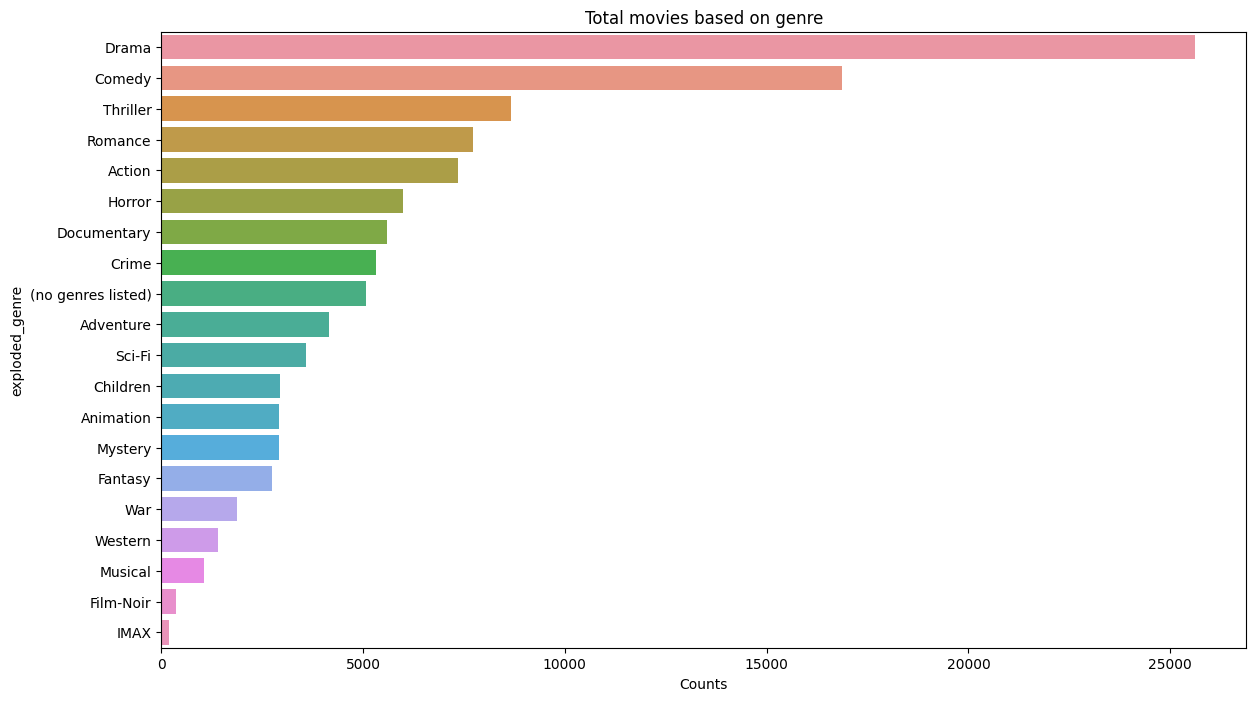

In [ ]:
plt.figure(figsize=(14,8))
sns.barplot(data = movies_exploded_pandas, x = 'count', y = 'exploded_genre')
plt.xlabel('Counts')
plt.title('Total movies based on genre')
plt.show()

In [ ]:
merge_df = df_ratings.select('movieid', 'rating').join(movies_exploded.select('movieid', 'exploded_genre'), on = ['movieid'])

In [ ]:
merge_df = merge_df.groupBy('exploded_genre').mean('rating')

In [ ]:
merge_df = merge_df.toPandas()

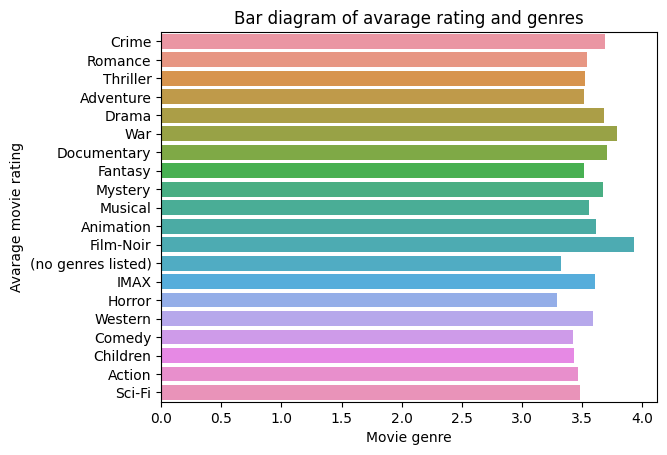

In [ ]:
sns.barplot(data = merge_df, x = 'avg(rating)', y = 'exploded_genre')
plt.xlabel('Movie genre')
plt.ylabel('Avarage movie rating')
plt.title('Bar diagram of avarage rating and genres')
plt.show()

In [ ]:
movies_df_year = df_movies.withColumn("year", f.regexp_extract(df_movies["title"], r'\((\d{4})\)$', 1))

In [ ]:
movies_df_year.show()

+-------+--------------------+--------------------+----+
|movieId|               title|              genres|year|
+-------+--------------------+--------------------+----+
|      1|    Toy Story (1995)|Adventure|Animati...|1995|
|      2|      Jumanji (1995)|Adventure|Childre...|1995|
|      3|Grumpier Old Men ...|      Comedy|Romance|1995|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|1995|
|      5|Father of the Bri...|              Comedy|1995|
|      6|         Heat (1995)|Action|Crime|Thri...|1995|
|      7|      Sabrina (1995)|      Comedy|Romance|1995|
|      8| Tom and Huck (1995)|  Adventure|Children|1995|
|      9| Sudden Death (1995)|              Action|1995|
|     10|    GoldenEye (1995)|Action|Adventure|...|1995|
|     11|American Presiden...|Comedy|Drama|Romance|1995|
|     12|Dracula: Dead and...|       Comedy|Horror|1995|
|     13|        Balto (1995)|Adventure|Animati...|1995|
|     14|        Nixon (1995)|               Drama|1995|
|     15|Cutthroat Island ...|A

In [ ]:
movies_df_year.count()

62423

In [ ]:
movies_df = Genre_split.select('*').join(movies_df_year.select('movieid', 'year'), on = ['movieid'])
movies_df.show()

+-------+-----+--------------------+--------------------+--------+-----+------+-----------+-------+------+---------+-------+--------+-------+------------------+-------+------+------+-----+-------+----+---------+---------+---+----+
|movieid|index|               title|               genre|Children|Crime|Action|Documentary|Western|Horror|Adventure|Fantasy|Thriller|Mystery|(no genres listed)|Musical|Comedy|Sci-Fi|Drama|Romance|IMAX|Animation|Film-Noir|War|year|
+-------+-----+--------------------+--------------------+--------+-----+------+-----------+-------+------+---------+-------+--------+-------+------------------+-------+------+------+-----+-------+----+---------+---------+---+----+
|      1|    0|    Toy Story (1995)|[Adventure, Anima...|       1|    0|     0|          0|      0|     0|        1|      1|       0|      0|                 0|      0|     1|     0|    0|      0|   0|        1|        0|  0|1995|
|      2|    1|      Jumanji (1995)|[Adventure, Child...|       1|    0|    

In [ ]:
movies_df_year = movies_df_year.groupBy(movies_df_year.year).count()
movies_df_year = movies_df_year.orderBy(movies_df_year["count"].desc())

In [ ]:
movie_features = movies_df
movie_features = movie_features.withColumnRenamed("movieid", "movieId")
columns_to_drop = ['title', 'genre', 'index']
movie_features = movie_features.drop(*columns_to_drop)
movie_features.show()

+-------+--------+-----+------+-----------+-------+------+---------+-------+--------+-------+------------------+-------+------+------+-----+-------+----+---------+---------+---+----+
|movieId|Children|Crime|Action|Documentary|Western|Horror|Adventure|Fantasy|Thriller|Mystery|(no genres listed)|Musical|Comedy|Sci-Fi|Drama|Romance|IMAX|Animation|Film-Noir|War|year|
+-------+--------+-----+------+-----------+-------+------+---------+-------+--------+-------+------------------+-------+------+------+-----+-------+----+---------+---------+---+----+
|      1|       1|    0|     0|          0|      0|     0|        1|      1|       0|      0|                 0|      0|     1|     0|    0|      0|   0|        1|        0|  0|1995|
|      2|       1|    0|     0|          0|      0|     0|        1|      1|       0|      0|                 0|      0|     0|     0|    0|      0|   0|        0|        0|  0|1995|
|      3|       0|    0|     0|          0|      0|     0|        0|      0|       0|

In [ ]:
movie_features = movie_features.join(df_ratings.groupBy("movieId").agg(f.avg("rating").alias("avg_rating")), on="movieId", how="left")
cols = movie_features.columns
cols = [cols[0], cols[-2], cols[-1]] + cols[1:-2]
movie_features = movie_features.select(cols)
movie_features.show()

+-------+----+------------------+--------+-----+------+-----------+-------+------+---------+-------+--------+-------+------------------+-------+------+------+-----+-------+----+---------+---------+---+
|movieId|year|        avg_rating|Children|Crime|Action|Documentary|Western|Horror|Adventure|Fantasy|Thriller|Mystery|(no genres listed)|Musical|Comedy|Sci-Fi|Drama|Romance|IMAX|Animation|Film-Noir|War|
+-------+----+------------------+--------+-----+------+-----------+-------+------+---------+-------+--------+-------+------------------+-------+------+------+-----+-------+----+---------+---------+---+
|      7|1995|3.3636663369601054|       0|    0|     0|          0|      0|     0|        0|      0|       0|      0|                 0|      0|     1|     0|    0|      1|   0|        0|        0|  0|
|     15|1995|2.7190217391304348|       0|    0|     1|          0|      0|     0|        1|      0|       0|      0|                 0|      0|     0|     0|    0|      1|   0|        0|     

In [ ]:
feature_columns = movie_features.columns[1:]
num_features = len(feature_columns)
print("There are a total", num_features, "features for a movie.\n")
print("Features for Movie are:\n\n", feature_columns)

There are a total 22 features for a movie.

Features for Movie are:

 ['year', 'avg_rating', 'Children', 'Crime', 'Action', 'Documentary', 'Western', 'Horror', 'Adventure', 'Fantasy', 'Thriller', 'Mystery', '(no genres listed)', 'Musical', 'Comedy', 'Sci-Fi', 'Drama', 'Romance', 'IMAX', 'Animation', 'Film-Noir', 'War']


In [ ]:
user_features = df_ratings.select("userId", "movieId", "rating").join(Genres_df.select("movieId", "genres"), on="movieId", how="left")
user_features = user_features.withColumn("genre", split(user_features["genres"], "\|"))
user_features = user_features.select("userId", "movieId", "rating", explode(user_features["genre"]).alias("genres"))
user_features.show()

+------+-------+------+--------+
|userId|movieId|rating|  genres|
+------+-------+------+--------+
|     1|    296|   5.0|  Comedy|
|     1|    296|   5.0|   Crime|
|     1|    296|   5.0|   Drama|
|     1|    296|   5.0|Thriller|
|     1|    306|   3.5|   Drama|
|     1|    307|   5.0|   Drama|
|     1|    665|   5.0|  Comedy|
|     1|    665|   5.0|   Drama|
|     1|    665|   5.0|     War|
|     1|    899|   3.5|  Comedy|
|     1|    899|   3.5| Musical|
|     1|    899|   3.5| Romance|
|     1|   1088|   4.0|   Drama|
|     1|   1088|   4.0| Musical|
|     1|   1088|   4.0| Romance|
|     1|   1175|   3.5|  Comedy|
|     1|   1175|   3.5|   Drama|
|     1|   1175|   3.5| Romance|
|     1|   1217|   3.5|   Drama|
|     1|   1217|   3.5|     War|
+------+-------+------+--------+
only showing top 20 rows



In [ ]:
user_features = user_features.groupBy("userId", "genres").agg(f.mean("rating").alias("mean_rating"))
user_features.show()

+------+---------+------------------+
|userId|   genres|       mean_rating|
+------+---------+------------------+
|    33|    Drama| 4.205882352941177|
|    47|  Western|               4.0|
|    71|   Action|              4.25|
|   139|  Musical|              3.25|
|   163|      War|              3.75|
|   164|  Fantasy|3.9285714285714284|
|   169|  Western|              3.75|
|   172|    Drama|           3.84375|
|   174|  Musical|               2.5|
|   183|    Drama|4.2105263157894735|
|   183|      War| 4.666666666666667|
|   184|Adventure| 3.730769230769231|
|   202|    Drama|             3.125|
|   205|  Fantasy|               3.0|
|   220|  Western|               3.0|
|   229|     IMAX| 4.333333333333333|
|   235|   Horror|            4.6875|
|   240|    Drama|               4.7|
|   266|Adventure|             2.875|
|   282|Animation| 4.910714285714286|
+------+---------+------------------+
only showing top 20 rows



In [ ]:
user_features = user_features.groupBy("userId").pivot("genres").agg(f.coalesce(f.mean("mean_rating")))

In [ ]:
user_features.show()

+------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|userId|(no genres listed)|            Action|         Adventure|         Animation|          Children|            Comedy|             Crime|       Documentary|             Drama|           Fantasy|         Film-Noir|            Horror|              IMAX|           Musical|           Mystery|           Romance|            Sci-Fi|          Thriller|               War|           Western|
+------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----

In [ ]:
user_features.count()

162541

In [ ]:
genres_list = user_features.columns[1:]
for genre in genres_list:
    user_features = user_features.withColumn(genre, f.coalesce(user_features[genre], f.lit(0)))
user_features.show()

+------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|userId|(no genres listed)|            Action|         Adventure|         Animation|          Children|            Comedy|             Crime|       Documentary|             Drama|           Fantasy|         Film-Noir|            Horror|              IMAX|           Musical|           Mystery|           Romance|            Sci-Fi|          Thriller|               War|           Western|
+------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----

In [ ]:
user_features.printSchema()

root
 |-- userId: string (nullable = true)
 |-- (no genres listed): double (nullable = false)
 |-- Action: double (nullable = false)
 |-- Adventure: double (nullable = false)
 |-- Animation: double (nullable = false)
 |-- Children: double (nullable = false)
 |-- Comedy: double (nullable = false)
 |-- Crime: double (nullable = false)
 |-- Documentary: double (nullable = false)
 |-- Drama: double (nullable = false)
 |-- Fantasy: double (nullable = false)
 |-- Film-Noir: double (nullable = false)
 |-- Horror: double (nullable = false)
 |-- IMAX: double (nullable = false)
 |-- Musical: double (nullable = false)
 |-- Mystery: double (nullable = false)
 |-- Romance: double (nullable = false)
 |-- Sci-Fi: double (nullable = false)
 |-- Thriller: double (nullable = false)
 |-- War: double (nullable = false)
 |-- Western: double (nullable = false)



In [ ]:
user_features = user_features.withColumn("userId", user_features["userId"].cast('integer'))
user_features = user_features.orderBy(user_features["userId"])
user_features.show()

+------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|userId|(no genres listed)|            Action|         Adventure|         Animation|          Children|            Comedy|             Crime|       Documentary|             Drama|           Fantasy|         Film-Noir|            Horror|              IMAX|           Musical|           Mystery|           Romance|            Sci-Fi|          Thriller|               War|           Western|
+------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----

In [ ]:
user_features.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- (no genres listed): double (nullable = false)
 |-- Action: double (nullable = false)
 |-- Adventure: double (nullable = false)
 |-- Animation: double (nullable = false)
 |-- Children: double (nullable = false)
 |-- Comedy: double (nullable = false)
 |-- Crime: double (nullable = false)
 |-- Documentary: double (nullable = false)
 |-- Drama: double (nullable = false)
 |-- Fantasy: double (nullable = false)
 |-- Film-Noir: double (nullable = false)
 |-- Horror: double (nullable = false)
 |-- IMAX: double (nullable = false)
 |-- Musical: double (nullable = false)
 |-- Mystery: double (nullable = false)
 |-- Romance: double (nullable = false)
 |-- Sci-Fi: double (nullable = false)
 |-- Thriller: double (nullable = false)
 |-- War: double (nullable = false)
 |-- Western: double (nullable = false)



In [ ]:
# user_features_csv = user_features.toPandas()

In [ ]:
# user_features_csv.to_csv("user_features_csv.csv", index=False)

In [ ]:
user_to_movies = df_ratings.groupBy("userId").agg(collect_list("movieId").alias("MoviesRated"))
user_to_movies.show()

+------+--------------------+
|userId|         MoviesRated|
+------+--------------------+
|   100|[5, 17, 25, 26, 3...|
| 10000|[1, 2, 110, 231, ...|
|100005|[1, 110, 327, 377...|
|100006|[1, 19, 110, 150,...|
|100008|[2, 6, 21, 32, 45...|
| 10001|[80, 1073, 1707, ...|
|100010|[1, 6, 7, 18, 25,...|
|100014|[1, 47, 165, 260,...|
|100021|[7, 11, 17, 110, ...|
|100022|[10, 32, 110, 111...|
|100025|[3, 104, 150, 432...|
|100029|[304, 603, 858, 1...|
|100031|[1, 2, 3, 5, 18, ...|
|100039|[1, 2, 3, 7, 11, ...|
|100040|[3, 10, 34, 44, 6...|
|100046|[1, 2, 16, 17, 47...|
|100054|[593, 765, 1029, ...|
|100060|[18, 47, 223, 296...|
|100062|[6, 23, 32, 50, 1...|
|100068|[47, 63, 296, 318...|
+------+--------------------+
only showing top 20 rows



In [ ]:
# user_to_movies_csv = user_to_movies.toPandas()
# user_to_movies_csv.to_csv('user_to_movies_csv.csv', index = False)

In [ ]:
user_to_movies_csv = pd.read_csv('/content/drive/MyDrive/MovieLens Dataset/user_to_movies_csv.csv')
user_to_movies_csv.head()

,userId,MoviesRated
0,100,"['5', '17', '25', '26', '32', '36', '52', '58'..."
1,10000,"['1', '2', '110', '231', '318', '356', '364', ..."
2,100005,"['1', '110', '327', '377', '457', '480', '540'..."
3,100006,"['1', '19', '110', '150', '160', '185', '208',..."
4,100008,"['2', '6', '21', '32', '45', '50', '110', '150..."


In [ ]:
userToMoviesRated = pd.Series(user_to_movies_csv['MoviesRated'], index=user_to_movies_csv['userId']).to_dict()

In [ ]:
with open("userToMoviesRated.pickle","wb") as f:
    pickle.dump(userToMoviesRated,f)

In [ ]:
X_users_data = df_ratings.select('userId').join(user_features, on="userId", how="left")
X_users_data = X_users_data.drop("userId")

In [ ]:
X_users_data.show()

+------------------+------+-----------------+---------+------------------+-----------------+------+-----------+------------------+-------+---------+------+----+-------+-------+-----------------+------+--------+---+-------+
|(no genres listed)|Action|        Adventure|Animation|          Children|           Comedy| Crime|Documentary|             Drama|Fantasy|Film-Noir|Horror|IMAX|Musical|Mystery|          Romance|Sci-Fi|Thriller|War|Western|
+------------------+------+-----------------+---------+------------------+-----------------+------+-----------+------------------+-------+---------+------+----+-------+-------+-----------------+------+--------+---+-------+
|               0.0| 4.125|3.727272727272727|      4.0|3.8333333333333335|3.869565217391304|4.0625|        2.0|3.8679245283018866|    3.6|      3.5|   3.5| 0.0|    3.7|    3.5|4.166666666666667|   3.7|     4.3|3.9|    2.5|
|               0.0| 4.125|3.727272727272727|      4.0|3.8333333333333335|3.869565217391304|4.0625|        2

In [ ]:
X_movies_data = df_ratings.select('movieId').join(movie_features, on="movieId", how="left")
X_movies_data = X_users_data.drop("movieId")

In [ ]:
X_movies_data.show()

+------------------+------+-----------------+---------+------------------+-----------------+------+-----------+------------------+-------+---------+------+----+-------+-------+-----------------+------+--------+---+-------+
|(no genres listed)|Action|        Adventure|Animation|          Children|           Comedy| Crime|Documentary|             Drama|Fantasy|Film-Noir|Horror|IMAX|Musical|Mystery|          Romance|Sci-Fi|Thriller|War|Western|
+------------------+------+-----------------+---------+------------------+-----------------+------+-----------+------------------+-------+---------+------+----+-------+-------+-----------------+------+--------+---+-------+
|               0.0| 4.125|3.727272727272727|      4.0|3.8333333333333335|3.869565217391304|4.0625|        2.0|3.8679245283018866|    3.6|      3.5|   3.5| 0.0|    3.7|    3.5|4.166666666666667|   3.7|     4.3|3.9|    2.5|
|               0.0| 4.125|3.727272727272727|      4.0|3.8333333333333335|3.869565217391304|4.0625|        2

In [ ]:
X_movies_data.show()

In [ ]:
# X_movies_data.to_csv('X_movies_data.csv')

In [ ]:
ratings_df = pd.read_csv('/content/drive/MyDrive/MovieLens Dataset/ratings.csv')

In [ ]:
Y_ratings = ratings_df[["rating"]]
Y_ratings

,rating
0,5.0
1,3.5
2,5.0
3,5.0
4,3.5
...,...
25000090,4.5
25000091,2.5
25000092,2.0
25000093,4.0


In [ ]:
del movie_features, user_features, ratings_df
gc.collect()

0

In [ ]:
X_movies_scaled = X_movies_data.values

scalerMovie = StandardScaler()
X_movies_scaled[:,0:2] = scalerMovie.fit_transform(X_movies_data.iloc[:,0:2])

scalerUser = MaxAbsScaler()
X_users_scaled = scalerUser.fit_transform(X_users_data)

scalerTarget = MinMaxScaler((-1,1))
Y_ratings_scaled = scalerTarget.fit_transform(Y_ratings)

In [ ]:
with open("scalerUser.pickle","wb") as f:
    pickle.dump(scalerUser, f)
with open("scalerMovie.pickle","wb") as f:
    pickle.dump(scalerMovie, f)
with open("scalerTarget.pickle","wb") as f:
    pickle.dump(scalerTarget, f)

In [ ]:
np.savez_compressed("data",X_movies_scaled,X_users_scaled, Y_ratings_scaled)

In [ ]:
del X_users_data, X_movies_data, Y_ratings
gc.collect()

In [ ]:
import numpy as np
data = np.load("/content/drive/MyDrive/MovieLens Dataset/data.npz")

In [ ]:
X_movies_scaled = data["arr_0"]
X_users_scaled = data["arr_1"]
Y_ratings_scaled = data["arr_2"]

In [ ]:
Y_ratings_scaled

array([[ 1.        ],
       [ 0.33333333],
       [ 1.        ],
       ...,
       [-0.33333333],
       [ 0.55555556],
       [ 1.        ]])

In [ ]:
x_movies_train, x_movies_test = train_test_split(X_movies_scaled, train_size=0.98, shuffle=True, random_state=1)
x_users_train, x_users_test = train_test_split(X_users_scaled, train_size=0.98, shuffle=True, random_state=1)
y_train, y_test = train_test_split(Y_ratings_scaled,    train_size=0.98, shuffle=True, random_state=1)
print(f"movie/item training data shape: {x_movies_train.shape}")
print(f"movie/item test data shape: {x_movies_test.shape}")

movie/item training data shape: (24500093, 22)
movie/item test data shape: (500002, 22)


In [ ]:
from numpy import asarray
from numpy import save
x_movies_train = asarray(x_movies_train)
save('x_movies_train.npy', x_movies_train)

In [ ]:
y_train

array([[-0.33333333],
       [ 0.11111111],
       [ 0.11111111],
       ...,
       [ 1.        ],
       [ 0.11111111],
       [ 0.55555556]])

In [ ]:
x_users_train = asarray(x_users_train)
save('x_users_train.npy', x_users_train)

In [ ]:
import gc
del X_movies_scaled, X_users_scaled, Y_ratings_scaled
gc.collect()

813

In [ ]:
num_user_features = 20 #x_users_train.shape[1]
num_item_features = 22 #x_movies_train.shape[1]
print("Number of user contents: ",num_user_features)
print("Number of movie contents: ",num_item_features)

Number of user contents:  20
Number of movie contents:  22


In [ ]:
gpus = tf.config.list_physical_devices('GPU');
if len(gpus) == 1:
    strategy = tf.distribute.OneDeviceStrategy(device='/gpu:0')
elif len(gpus) > 1:
    strategy = tf.distribute.MirroredStrategy()
else:
    #strategy = tf.distribute.OneDeviceStrategy(device='/cpu:0')
    strategy = None

In [ ]:
num_user_features

20

In [ ]:
num_item_features

22

In [ ]:
num_outputs = 32

def get_model():
    input_user  = tf.keras.layers.Input(shape=(num_user_features))
    input_item = tf.keras.layers.Input(shape=(num_item_features))

    user_NN = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation = 'relu'),
        tf.keras.layers.Dense(256, activation = 'relu'),
        #tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(128, activation = 'relu'),
        #tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(num_outputs)
    ])

    item_NN = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation = 'relu'),
        tf.keras.layers.Dense(256, activation = 'relu'),
        #tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(128, activation = 'relu'),
        #tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(num_outputs)
    ])

    dotProduct = tf.keras.layers.Dot(axes=1)



    output_user = user_NN(input_user)
    vu = tf.linalg.l2_normalize(output_user,axis=1)
    output_item = item_NN(input_item)
    vi = tf.linalg.l2_normalize(output_item,axis=1)
    #output = dotProduct([vu, vi])

    multiplied = tf.keras.layers.Multiply()([vu, vi])
    dense1 = tf.keras.layers.Dense(64, activation='relu')(multiplied)
    dense1 = tf.keras.layers.Dropout(0.1)(dense1)
    output = tf.keras.layers.Dense(1,activation='tanh')(dense1)



    model = tf.keras.Model([input_user, input_item],output)

    return model, user_NN, item_NN


In [ ]:
# exponential decay fn for the learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.005,
                                                            decay_steps=100000,
                                                            decay_rate=0.96)

adam = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
mae = tf.keras.losses.MeanAbsoluteError()

def rmse(y_true,y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(y_true,y_pred))))

# model, user_NN, movie_NN = get_model()
# model.compile(optimizer=adam, loss=mae)
# else:
model, user_NN, movie_NN = get_model()
model.compile(optimizer=adam, loss='huber_loss', metrics=['mse'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 20)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 22)]         0           []                               
                                                                                                  
 sequential (Sequential)        (None, 32)           72736       ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 32)           72992       ['input_2[0][0]']                
                                                                                              

In [ ]:
# making a separate model for outputing user feature vector
user_inp = tf.keras.layers.Input(shape=(num_user_features))
user_out = user_NN(user_inp)
user_out = tf.linalg.l2_normalize(user_out,axis=1)

model_user = tf.keras.Model(user_inp, user_out)

# separate model to output movie feature vectors
item_inp = tf.keras.layers.Input(shape=(num_item_features))
item_out = movie_NN(item_inp)
item_out = tf.linalg.l2_normalize(item_out,axis=1)

model_movie = tf.keras.Model(item_inp, item_out)

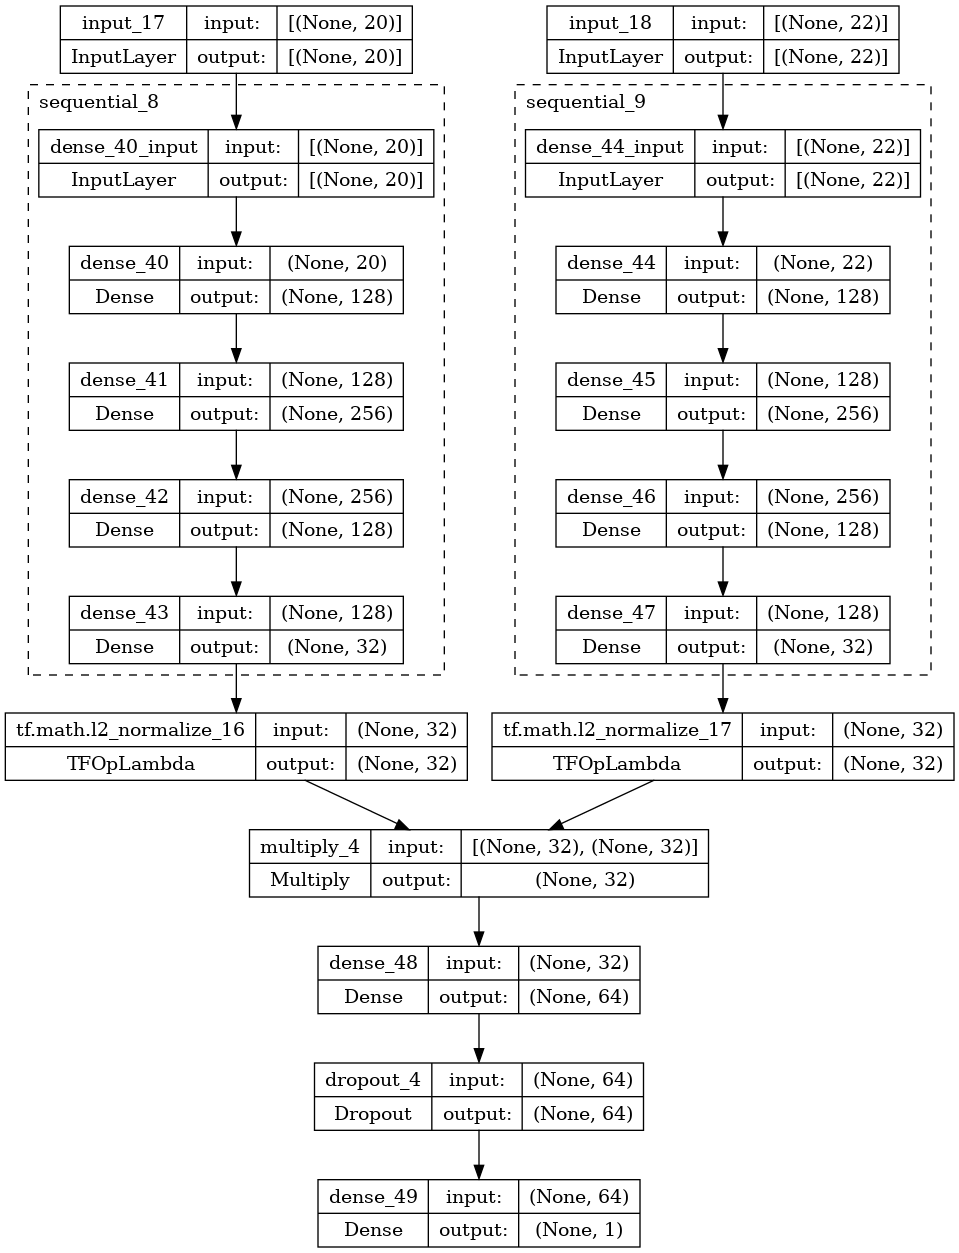

In [ ]:
tf.keras.utils.plot_model(model,"model.png",show_shapes=True, expand_nested=True)

In [ ]:
y_train

array([[-0.33333333],
       [ 0.11111111],
       [ 0.11111111],
       ...,
       [ 1.        ],
       [ 0.11111111],
       [ 0.55555556]])

# Testing From Here.

In [ ]:
hist = model.fit([x_users_train, x_movies_train],y_train, batch_size=1024, epochs=20,
                validation_split=0.01,
                shuffle=True)

Epoch 1/20
23687/23687 [==============================] - 112s 4ms/step - loss: 0.0677 - mse: 0.1364 - val_loss: 0.0654 - val_mse: 0.1318
Epoch 2/20
23687/23687 [==============================] - 104s 4ms/step - loss: 0.0649 - mse: 0.1307 - val_loss: 0.0644 - val_mse: 0.1296
Epoch 3/20
23687/23687 [==============================] - 105s 4ms/step - loss: 0.0639 - mse: 0.1288 - val_loss: 0.0629 - val_mse: 0.1267
Epoch 4/20
23687/23687 [==============================] - 104s 4ms/step - loss: 0.0630 - mse: 0.1268 - val_loss: 0.0625 - val_mse: 0.1258
Epoch 5/20
23687/23687 [==============================] - 104s 4ms/step - loss: 0.0626 - mse: 0.1260 - val_loss: 0.0632 - val_mse: 0.1275
Epoch 6/20
23687/23687 [==============================] - 104s 4ms/step - loss: 0.0623 - mse: 0.1253 - val_loss: 0.0618 - val_mse: 0.1245
Epoch 7/20
23687/23687 [==============================] - 103s 4ms/step - loss: 0.0619 - mse: 0.1247 - val_loss: 0.0616 - val_mse: 0.1240
Epoch 8/20
23687/23687 [==========

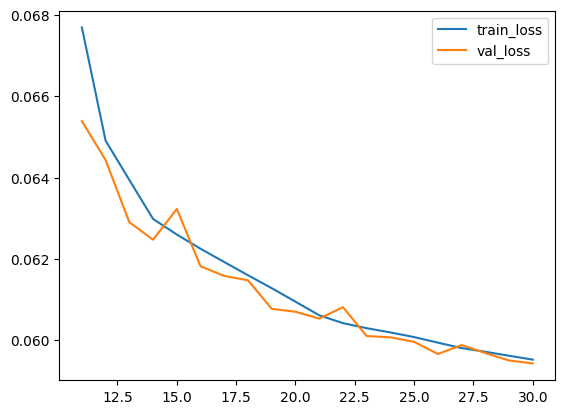

In [ ]:
plt.plot(range(11,10+len(hist.history['loss'])+1),hist.history['loss'],label="train_loss")
plt.plot(range(11,10+len(hist.history['val_loss'])+1),hist.history['val_loss'],label="val_loss")
plt.legend()
plt.show()

In [ ]:
model.evaluate([x_users_test, x_movies_test],y_test, batch_size=256, steps=10000)

10000/10000 [==============================] - 5s 485us/step - loss: 0.0592 - mse: 0.1191


[0.05921623483300209, 0.11914531141519547]

In [ ]:
model.save_weights("model_weights.h5")
model_user.save_weights("model_user_weights.h5")
model_movie.save_weights("model_item_weights.h5")

In [ ]:
del x_users_train,x_movies_train
gc.collect()

5398

In [ ]:
model, user_NN, movie_NN = get_model()

# making a separate model for outputing user feature vector
user_inp = tf.keras.layers.Input(shape=(num_user_features))
user_out = user_NN(user_inp)
user_out = tf.linalg.l2_normalize(user_out,axis=1)

model_user = tf.keras.Model(user_inp, user_out)

# separate model to output movie feature vectors
item_inp = tf.keras.layers.Input(shape=(num_item_features))
item_out = movie_NN(item_inp)
item_out = tf.linalg.l2_normalize(item_out,axis=1)

model_movie = tf.keras.Model(item_inp, item_out)

In [ ]:
model.load_weights("/kaggle/working/model_weights.h5")
model_user.load_weights("/kaggle/working/model_user_weights.h5")
model_movie.load_weights("/kaggle/working/model_item_weights.h5")

In [ ]:
movie_features = pd.read_csv('/kaggle/input/data-and-pickle/movie_features.csv')

In [ ]:
with open("/kaggle/input/data-and-pickle/scalerUser.pickle","rb") as f:
    scalerUser = pickle.load(f)
with open("/kaggle/input/data-and-pickle/scalerMovie.pickle","rb") as f:
    scalerMovie = pickle.load(f)
with open("/kaggle/input/data-and-pickle/scalerTarget.pickle","rb") as f:
    scalerTarget = pickle.load(f)

In [ ]:
movie_vecs_scaled = movie_features.drop(columns="movieId").values
movie_vecs_scaled[:,0:2] = scalerMovie.transform(movie_features.drop(columns="movieId").iloc[:,0:2])

In [ ]:
num_movies = movie_features.shape[0]
# num_users = user_features.shape[0]
print("Total Number of movies: ",num_movies)
# print("Total Number of uses: ",num_users)

Total Number of movies:  62423


In [ ]:
getMovieId = dict(movies_df['movieId'])
# mapper to get movie index in matrix given movie id
getMovieIdx = {value:key for key,value in getMovieId.items()}
# mapper from title to movie index
titleToMovieIdx = {movies_df.iloc[idx,1]:idx for idx in range(num_movies)}

In [ ]:
# getting model generated feature vectors for movies
movie_vecs_m = model_movie.predict(movie_vecs_scaled)

# store the similarity score of each movie with every other movie
similarMovies = cosine_similarity(movie_vecs_m)

#mask the diagonal scores as it represents similarity score with itself
similarMovies = ma.masked_array(similarMovies, mask=np.identity(num_movies))

print(similarMovies.shape)

1951/1951 [==============================] - 2s 1ms/step
(62423, 62423)


In [ ]:
def get_recommendations_movie(mtitle, top_N=10, similarMovies=similarMovies, titleToMovieIdx=titleToMovieIdx):
    movieIdx = titleToMovieIdx[mtitle]
    # negate the values to get highest score first
    sorted_idx = np.argsort(-similarMovies[movieIdx])

    sorted_movies = movies_df.iloc[sorted_idx].iloc[0:top_N]
    sorted_movies["similarity"] = similarMovies[movieIdx][sorted_idx][0:top_N]

    return sorted_movies.reset_index(drop=True)

In [ ]:
top_N = 10

# movie_idx = getMovieIdx[1]
movie_name  = "Iron Man (2008)"
# movie_genre = movies_df.iloc[movie_idx,2]
# print(f"Similar movies to {movie_name} with genre {movie_genre} are:\n\n")
sorted_movies = get_recommendations_movie(movie_name, top_N)
sorted_movies.head(top_N)

,movieId,title,genres,genre,(no genres listed),Action,Adventure,Animation,Children,Comedy,...,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year,similarity
0,63433,Farscape: The Peacekeeper Wars (2004),Action|Adventure|Sci-Fi,"[Action, Adventure, Sci-Fi]",0,1,1,0,0,0,...,0,0,0,0,1,0,0,0,2004,0.997086
1,111362,X-Men: Days of Future Past (2014),Action|Adventure|Sci-Fi,"[Action, Adventure, Sci-Fi]",0,1,1,0,0,0,...,0,0,0,0,1,0,0,0,2014,0.991376
2,3793,X-Men (2000),Action|Adventure|Sci-Fi,"[Action, Adventure, Sci-Fi]",0,1,1,0,0,0,...,0,0,0,0,1,0,0,0,2000,0.990487
3,112852,Guardians of the Galaxy (2014),Action|Adventure|Sci-Fi,"[Action, Adventure, Sci-Fi]",0,1,1,0,0,0,...,0,0,0,0,1,0,0,0,2014,0.990431
4,122918,Guardians of the Galaxy 2 (2017),Action|Adventure|Sci-Fi,"[Action, Adventure, Sci-Fi]",0,1,1,0,0,0,...,0,0,0,0,1,0,0,0,2017,0.989606
5,122922,Doctor Strange (2016),Action|Adventure|Sci-Fi,"[Action, Adventure, Sci-Fi]",0,1,1,0,0,0,...,0,0,0,0,1,0,0,0,2016,0.989479
6,34405,Serenity (2005),Action|Adventure|Sci-Fi,"[Action, Adventure, Sci-Fi]",0,1,1,0,0,0,...,0,0,0,0,1,0,0,0,2005,0.988946
7,122916,Thor: Ragnarok (2017),Action|Adventure|Sci-Fi,"[Action, Adventure, Sci-Fi]",0,1,1,0,0,0,...,0,0,0,0,1,0,0,0,2017,0.988731
8,191831,Nostradamus (2000),Action|Adventure|Sci-Fi,"[Action, Adventure, Sci-Fi]",0,1,1,0,0,0,...,0,0,0,0,1,0,0,0,2000,0.988501
9,122912,Avengers: Infinity War - Part I (2018),Action|Adventure|Sci-Fi,"[Action, Adventure, Sci-Fi]",0,1,1,0,0,0,...,0,0,0,0,1,0,0,0,2018,0.986162


In [ ]:
sorted_movies[['movieId', 'title', 'genres', 'year', 'similarity']]

,movieId,title,genres,year,similarity
0,63433,Farscape: The Peacekeeper Wars (2004),Action|Adventure|Sci-Fi,2004,0.997086
1,111362,X-Men: Days of Future Past (2014),Action|Adventure|Sci-Fi,2014,0.991376
2,3793,X-Men (2000),Action|Adventure|Sci-Fi,2000,0.990487
3,112852,Guardians of the Galaxy (2014),Action|Adventure|Sci-Fi,2014,0.990431
4,122918,Guardians of the Galaxy 2 (2017),Action|Adventure|Sci-Fi,2017,0.989606
5,122922,Doctor Strange (2016),Action|Adventure|Sci-Fi,2016,0.989479
6,34405,Serenity (2005),Action|Adventure|Sci-Fi,2005,0.988946
7,122916,Thor: Ragnarok (2017),Action|Adventure|Sci-Fi,2017,0.988731
8,191831,Nostradamus (2000),Action|Adventure|Sci-Fi,2000,0.988501
9,122912,Avengers: Infinity War - Part I (2018),Action|Adventure|Sci-Fi,2018,0.986162
